# Profiling
- See http://www.cs.cmu.edu/~ark/personas/ for raw dataset information.
- See `data/out/report.html` for a basic profiling report of the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_pickle('../data/out/data.pkl')
df.head()

,name,date,revenue,runtime,languages,countries,genres,summary,phrases
0,Blacksmith Scene,1893-01-01,NaN,0.566667,[Silent film],[United States of America],"[Black-and-white, Indie, Short, Silent]",The scene is all filmed from a stationary came...,"[anvil, beer, blacksmith, camera, metal]"
1,Miss Jerry,1894-10-09,NaN,NaN,[Silent film],[United States of America],"[Black-and-white, Indie, Short, Silent]",After finding out that her father is suffering...,"[editor, falls, financial problems, hamilton, ..."
2,Corbett and Courtney Before the Kinetograph,1894-11-17,NaN,NaN,[Silent film],[United States of America],"[Black-and-white, Indie, Short, Silent]",James J. Corbett and Peter Courtney both take ...,"[boxing, hero]"
3,La Mer,1895-01-01,NaN,0.633333,[Silent film],[France],"[Black-and-white, Documentary, Indie, Short, S...",This 38 second film has a very simple plot in ...,"[film, jetty, water]"
4,Autour d'une cabine,1895-01-01,NaN,15.000000,[Silent film],[France],"[Animation, Comedy, Indie, Short, Silent]",The film consists of a series of animations on...,"[beach, boat, diving, dog, film, play, swimmin..."


## Languages

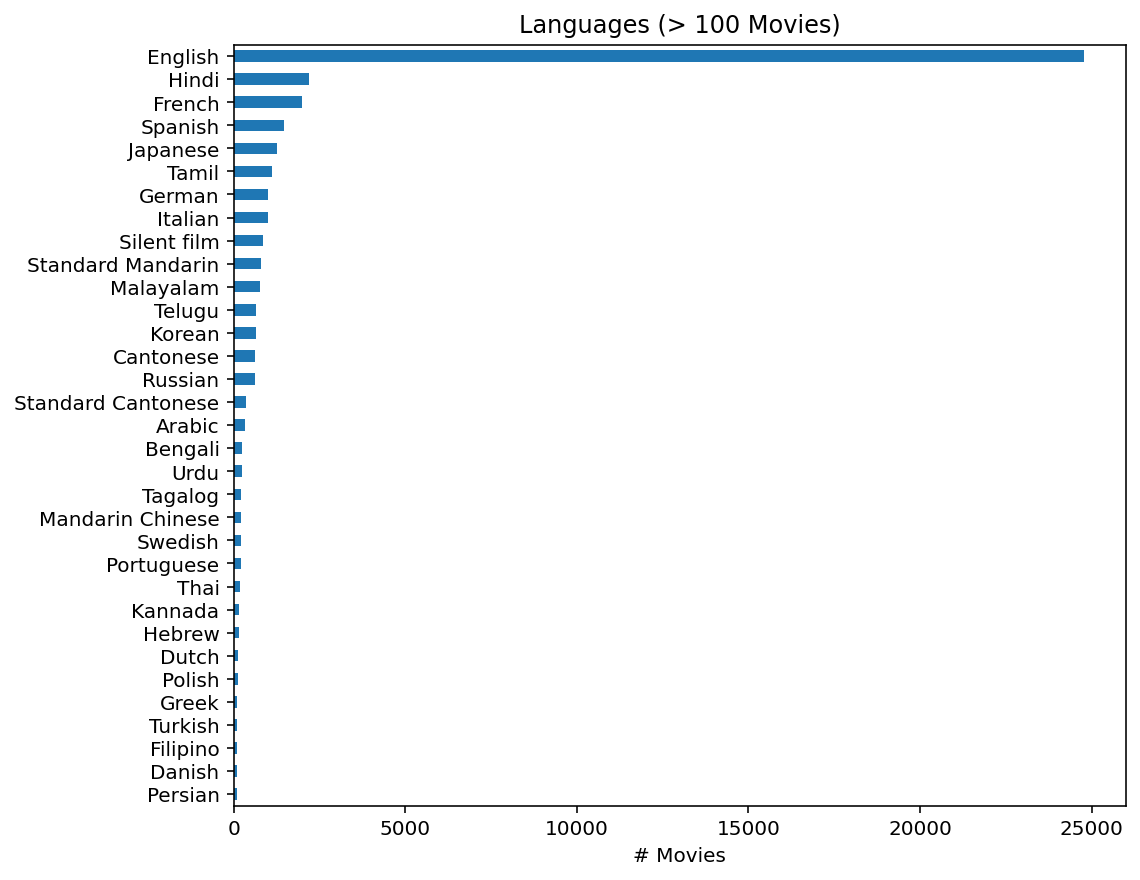

In [3]:
languages = df.languages.explode().value_counts().sort_index(ascending=False).sort_values(kind='mergesort')  # Sort languages by count, then alphabetically
fig, ax = plt.subplots(figsize=(8, 7))
languages[languages.gt(100)].plot.barh(ax=ax)
ax.set(title='Languages (> 100 Movies)', xlabel='# Movies');

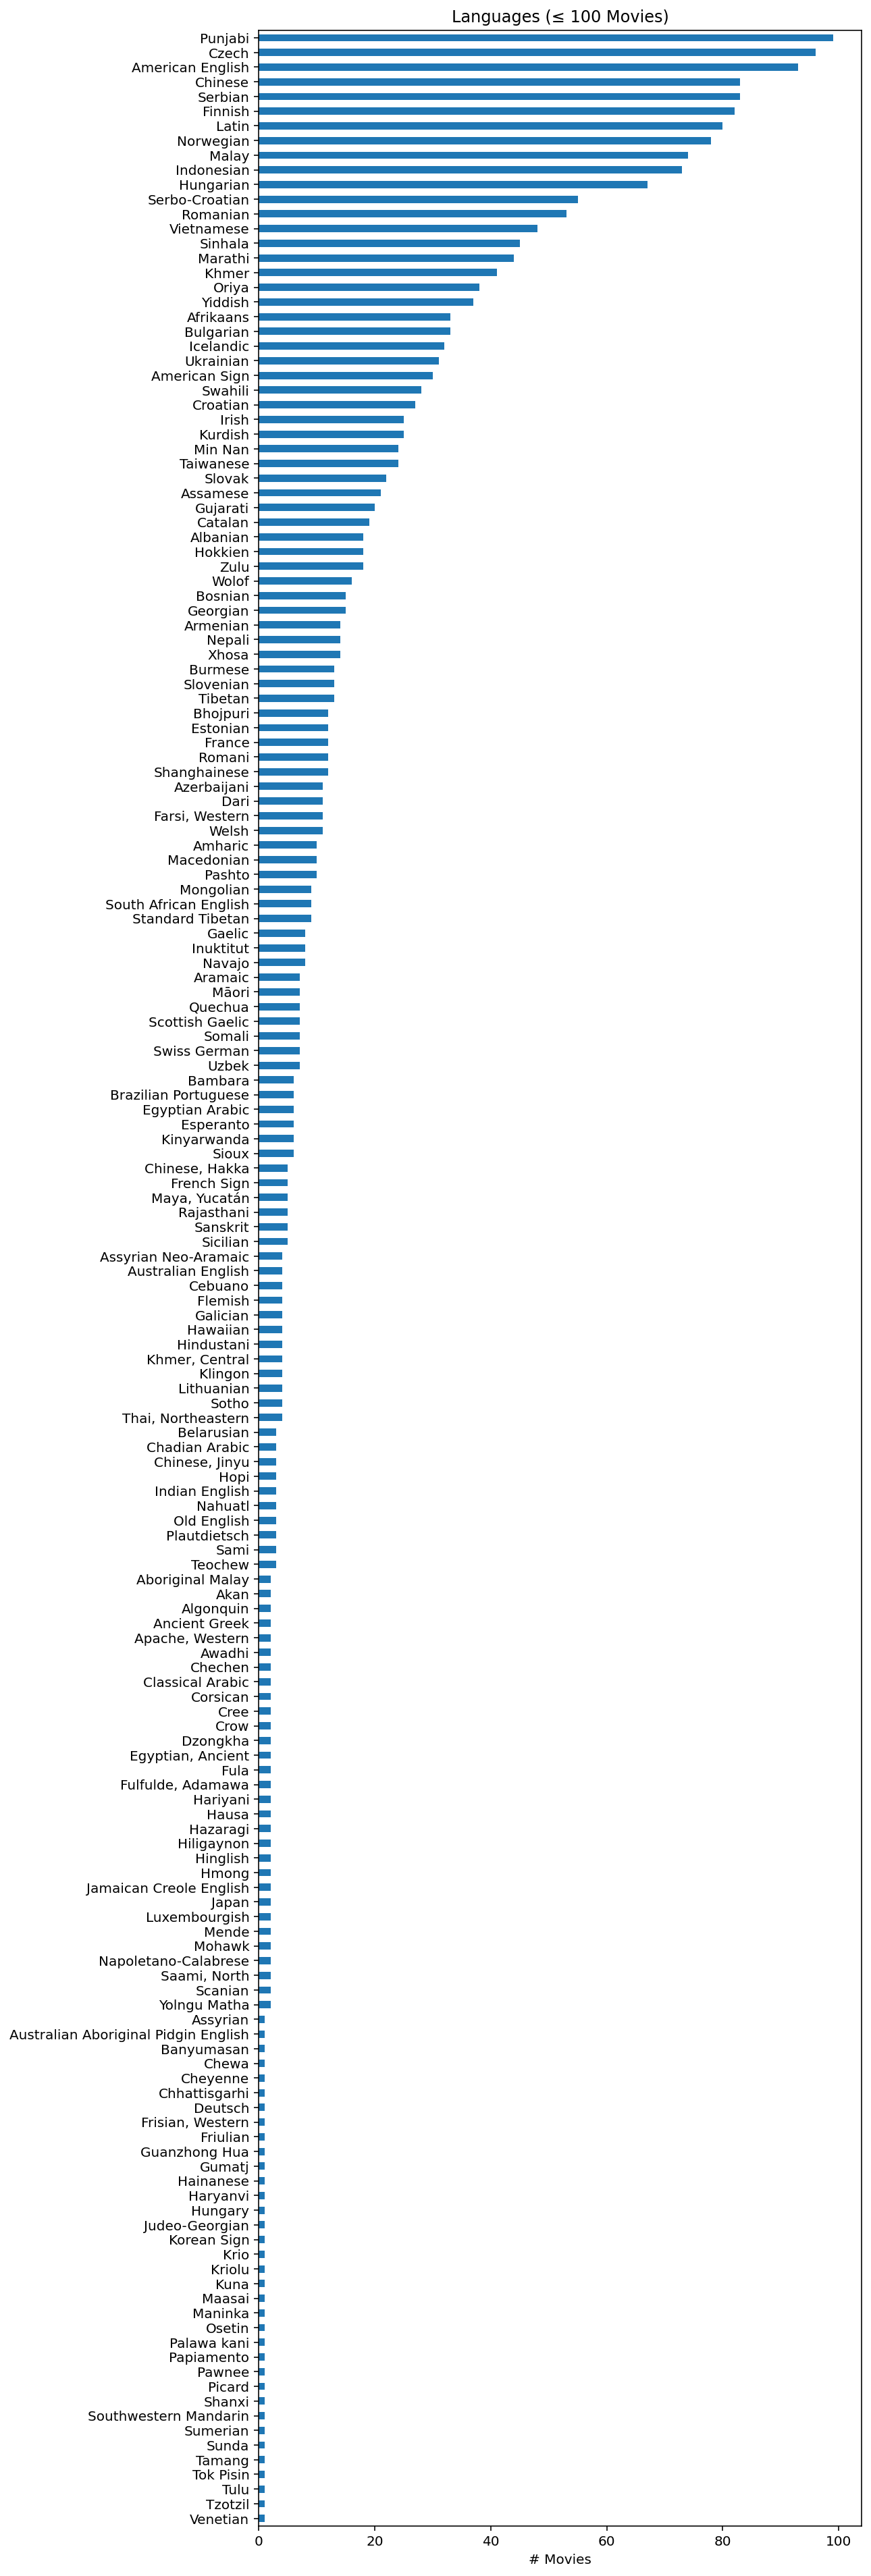

In [4]:
fig, ax = plt.subplots(figsize=(8, 34))
languages[~languages.gt(100)].plot.barh(ax=ax)
ax.set(title='Languages (≤ 100 Movies)', xlabel='# Movies');

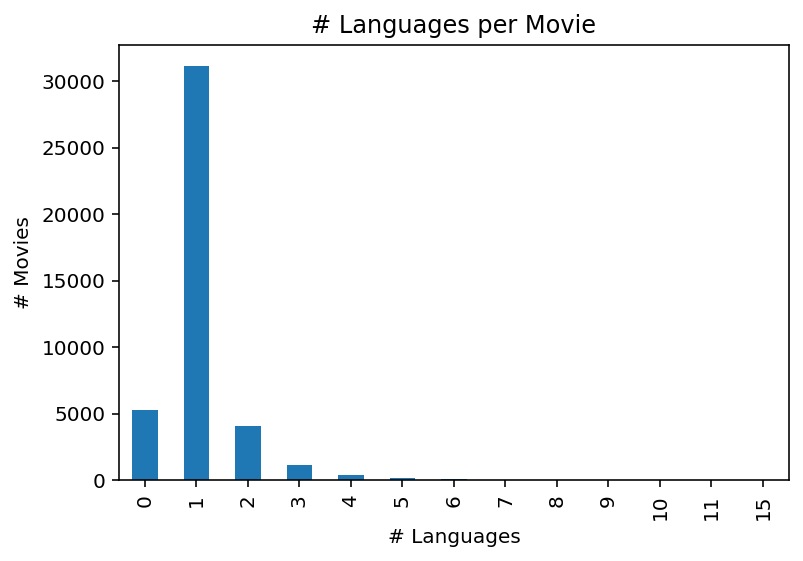

In [5]:
fig, ax = plt.subplots()
df.languages.str.len().value_counts().sort_index().plot.bar(ax=ax)
ax.set(title='# Languages per Movie', xlabel='# Languages', ylabel='# Movies');

## Countries
https://en.wikipedia.org/wiki/Country_of_origin#Film_and_television_production
> The International Federation of Film Archives defines the country of origin as the "country of the principal offices of the production company or individual by whom the moving image work was made". No consistent reference or definition exists. Sources include the item itself, accompanying material (e.g. scripts, shot lists, production records, publicity material, inventory lists, synopses etc.), the container (if not an integral part of the piece), or other sources (standard and special moving image reference tools).

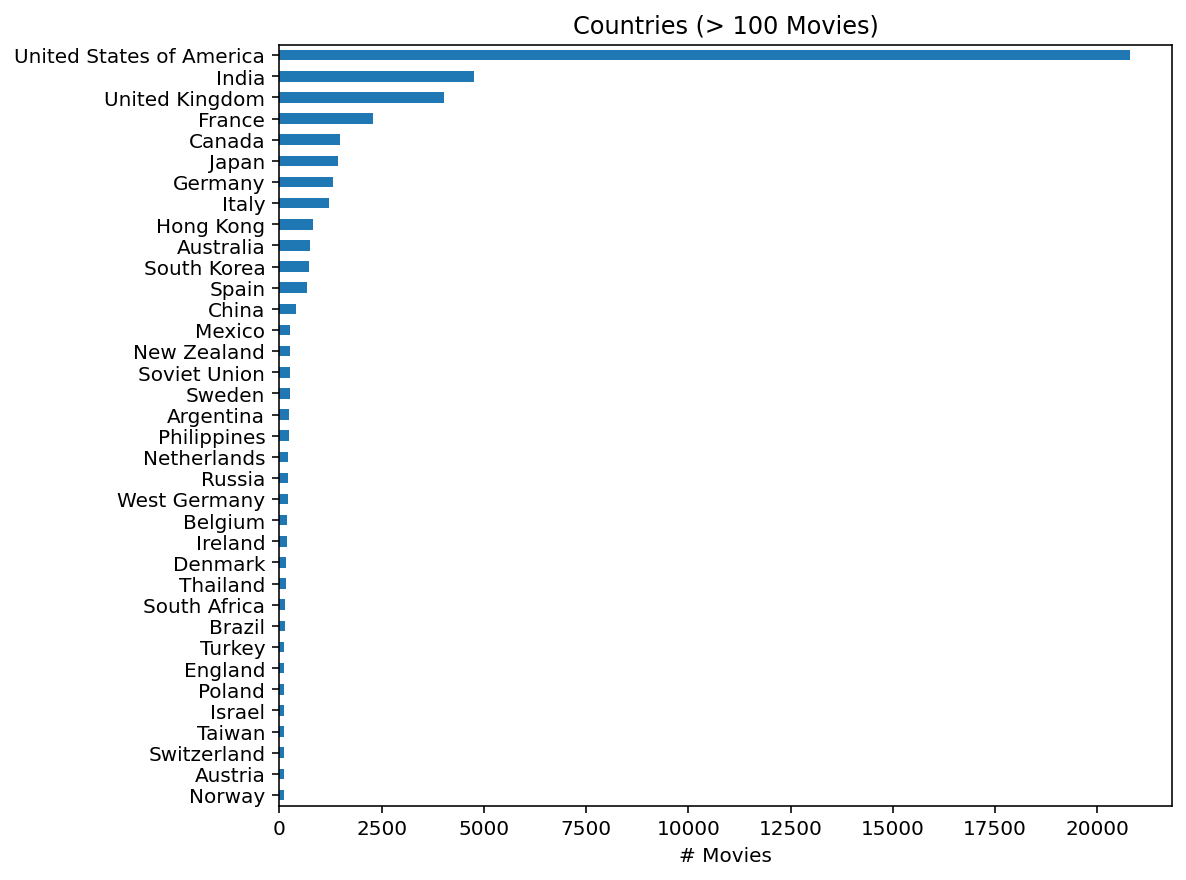

In [6]:
countries = df.countries.explode().value_counts().sort_index(ascending=False).sort_values(kind='mergesort')  # Sort countries by count, then alphabetically
fig, ax = plt.subplots(figsize=(8, 7))
countries[countries.gt(100)].plot.barh(ax=ax)
ax.set(title='Countries (> 100 Movies)', xlabel='# Movies');

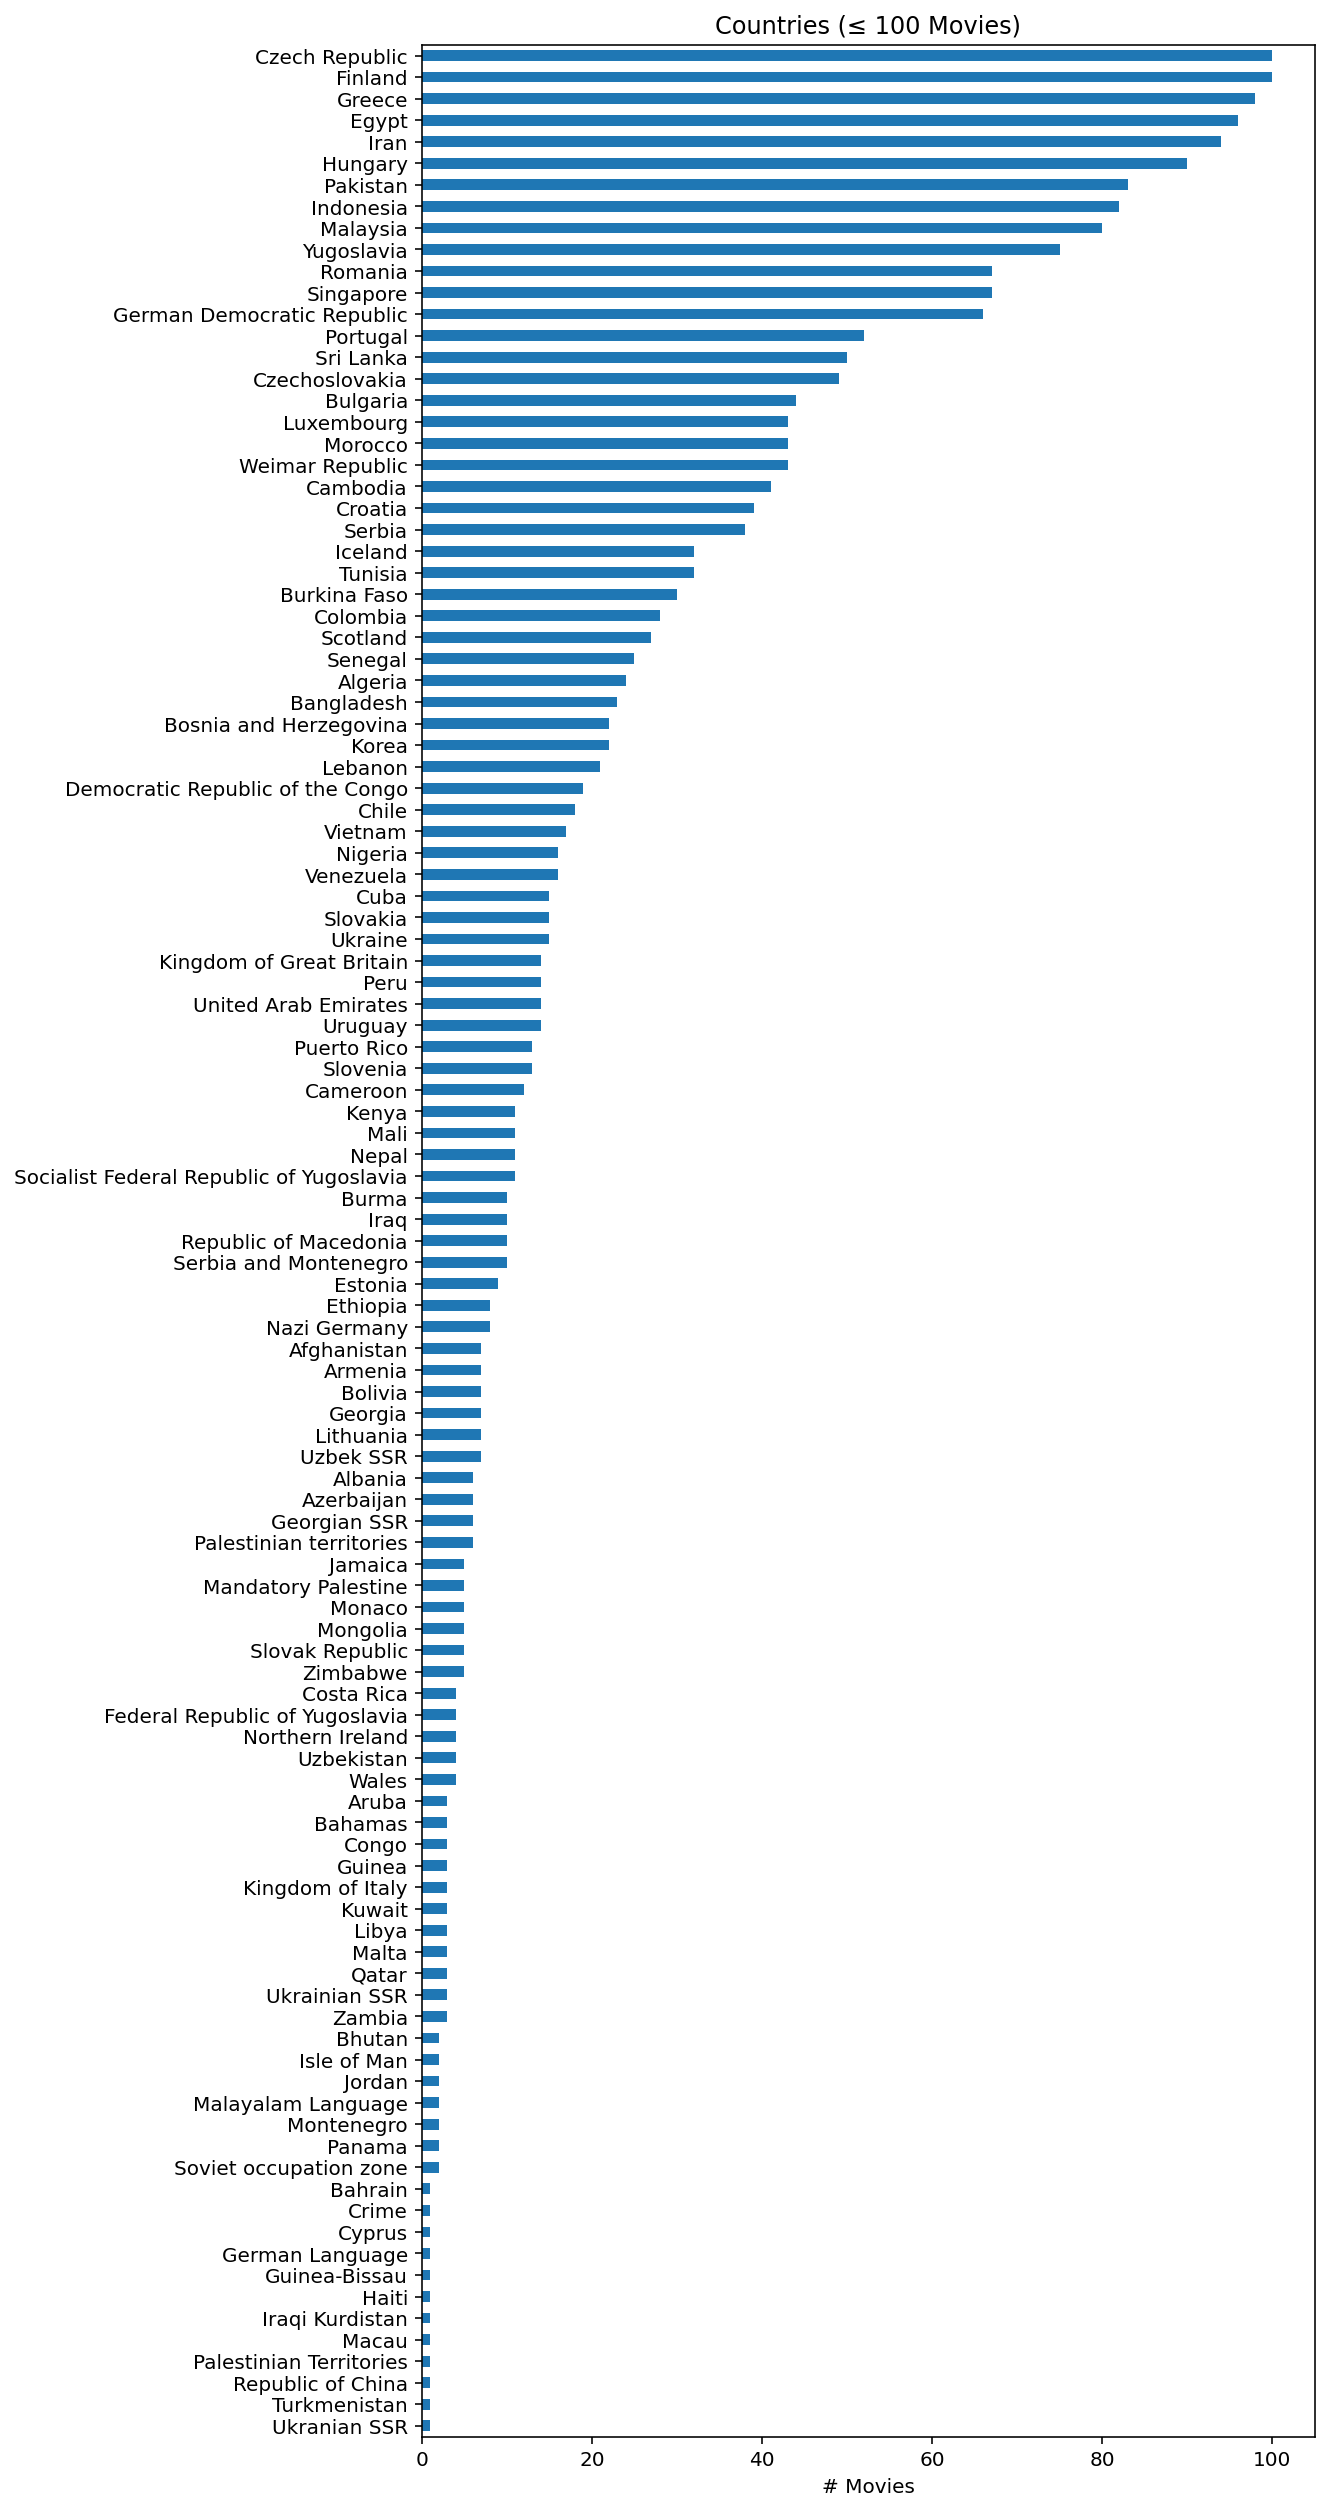

In [7]:
fig, ax = plt.subplots(figsize=(8, 22))
countries[~countries.gt(100)].plot.barh(ax=ax)
ax.set(title='Countries (≤ 100 Movies)', xlabel='# Movies');

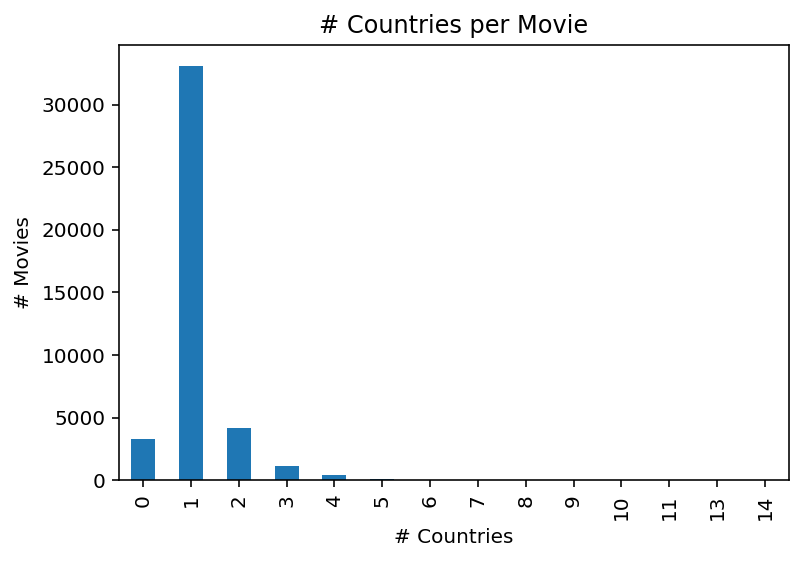

In [8]:
fig, ax = plt.subplots()
df.countries.str.len().value_counts().sort_index().plot.bar(ax=ax)
ax.set(title='# Countries per Movie', xlabel='# Countries', ylabel='# Movies');

## Genres
These are the genres after basic cleaning from `src/etl.py`. Depending on the purpose (e.g. classification), we may consider relabeling the genres into broader categories (see https://en.wikipedia.org/wiki/List_of_genres). Possible examples of relabeling (there are many more):
- Action/Adventure → {Action, Adventure}
- Romantic drama → {Romance, Drama}
- Gay → LGBT

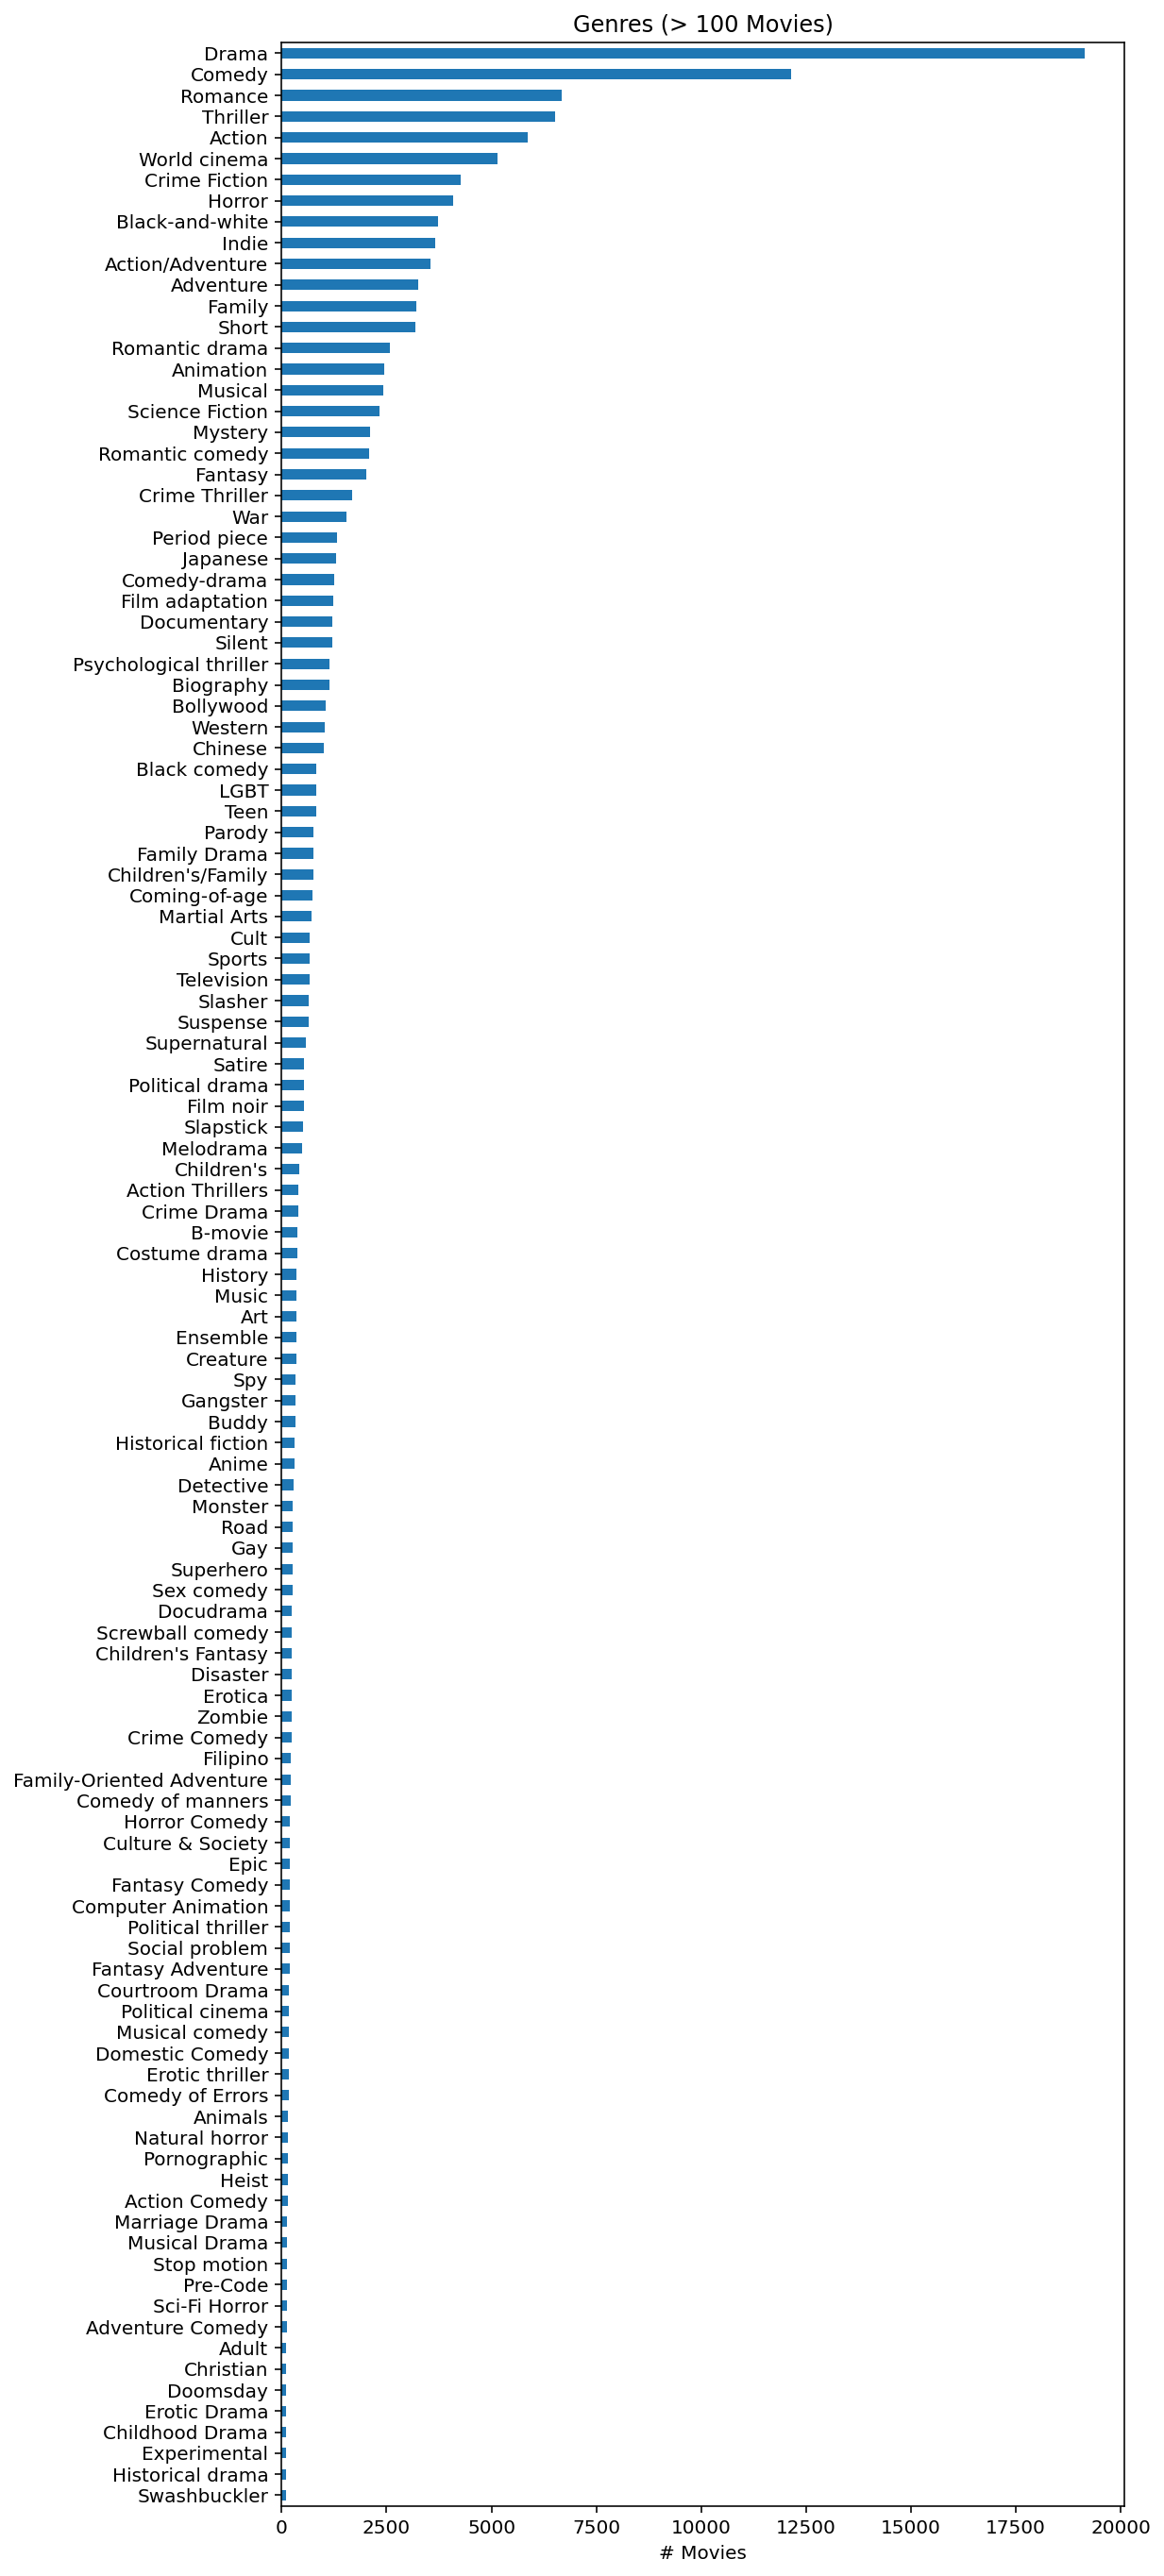

In [9]:
genres = df.genres.explode().value_counts().sort_index(ascending=False).sort_values(kind='mergesort')  # Sort genres by count, then alphabetically
fig, ax = plt.subplots(figsize=(8, 24))
genres[genres.gt(100)].plot.barh(ax=ax)
ax.set(title='Genres (> 100 Movies)', xlabel='# Movies');

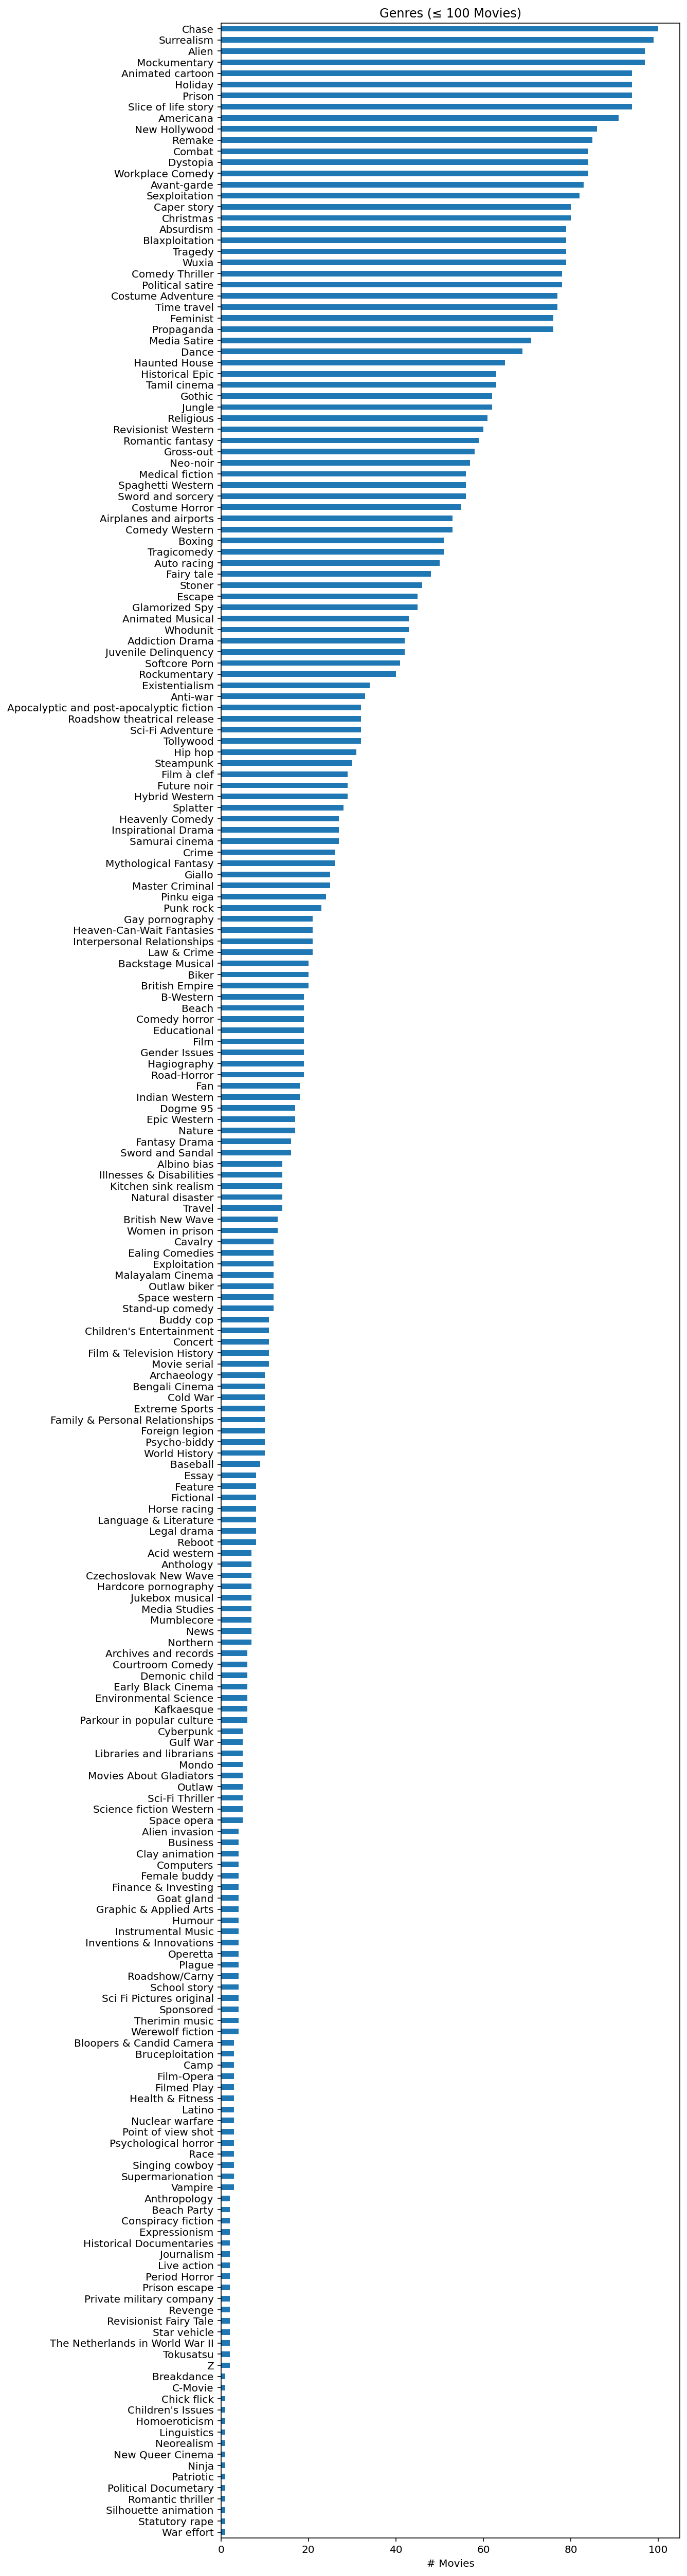

In [10]:
fig, ax = plt.subplots(figsize=(8, 45))
genres[~genres.gt(100)].plot.barh(ax=ax)
ax.set(title='Genres (≤ 100 Movies)', xlabel='# Movies');

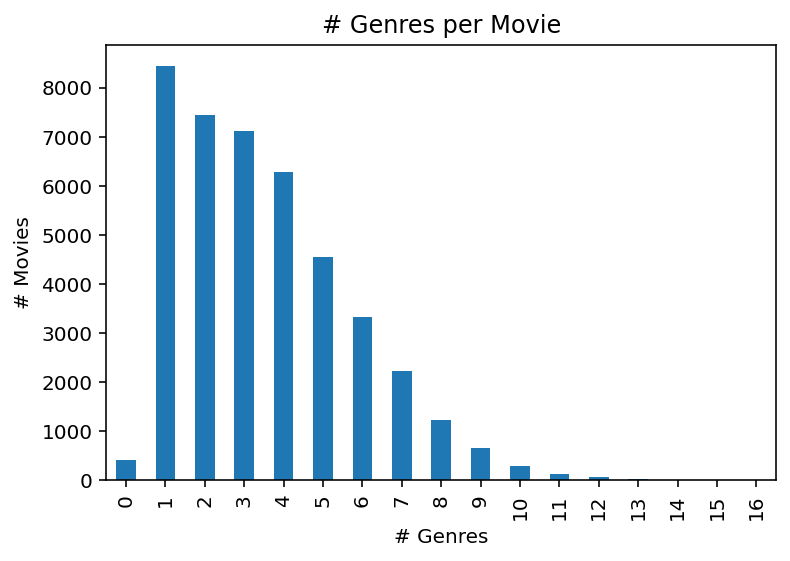

In [11]:
fig, ax = plt.subplots()
df.genres.str.len().value_counts().sort_index().plot.bar(ax=ax)
ax.set(title='# Genres per Movie', xlabel='# Genres', ylabel='# Movies');

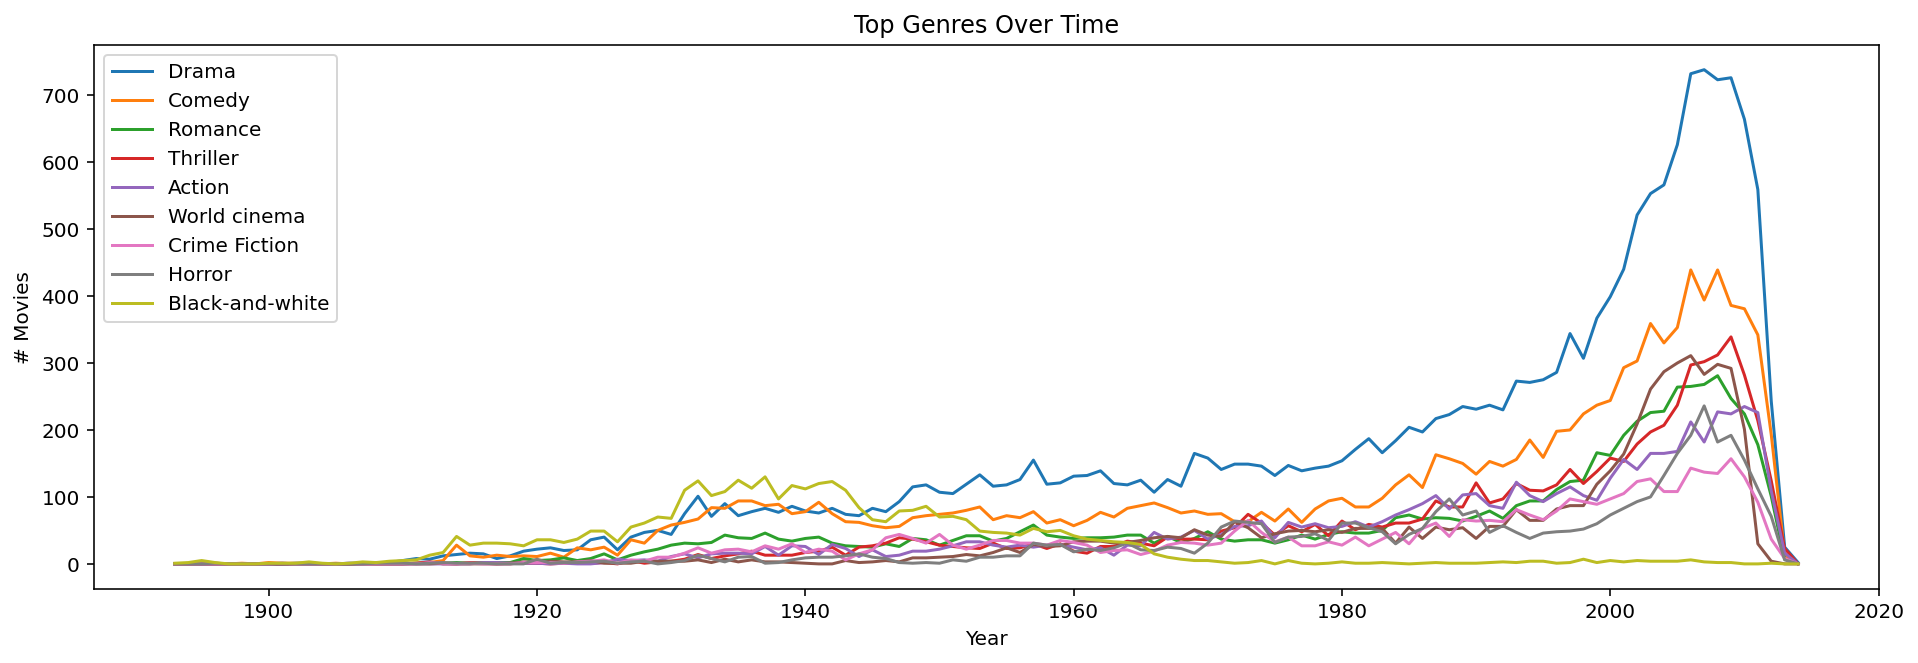

In [12]:
top_genres = df.genres.explode().value_counts().nlargest(9).index
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # Ignore UserWarnings from genres not in classes
    labels = pd.DataFrame(MultiLabelBinarizer(classes=top_genres).fit_transform(df.genres), columns=top_genres)
fig, ax = plt.subplots(figsize=(16, 5))
labels.groupby(df.date.dt.year).sum().plot(ax=ax)
ax.set(title='Top Genres Over Time', xlabel='Year', ylabel='# Movies');

## Phrases

In [13]:
single, multi = [pd.read_csv(f'../model/autophrase/{f}', header=None, index_col=1, sep='\t', squeeze=True)
                 for f in ('AutoPhrase_single-word.txt', 'AutoPhrase_multi-words.txt')]

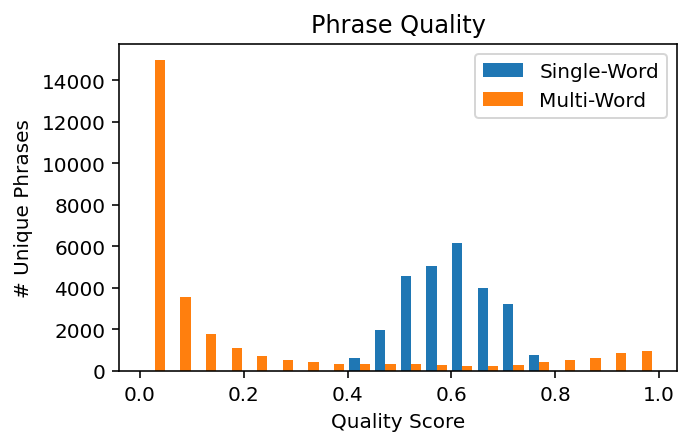

In [14]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist([single, multi], bins=20, label=['Single-Word', 'Multi-Word'])
ax.set(title='Phrase Quality', xlabel='Quality Score', ylabel='# Unique Phrases')
ax.legend();

In [15]:
single_examples, multi_examples, scores = [], [], []
for score in np.linspace(1, 0, 101):
    single_examples.append('' if (single - score).abs().min() > .005 else (single - score).abs().idxmin())
    multi_examples.append('' if (multi - score).abs().min() > .005 else (multi - score).abs().idxmin())
    scores.append(score)

with pd.option_context('display.max_rows', None):
    display(pd.DataFrame({
        'Score': scores,
        'Single-Word Phrase': single_examples,
        'Multi-Word Phrase': multi_examples
    }).set_index('Score'))

,Single-Word Phrase,Multi-Word Phrase
Score,,
1.00,,
0.99,,lois lane
0.98,,holy grail
0.97,,gold medal
0.96,,magic lamp
0.95,,singer songwriter
0.94,,toy store
0.93,,happy birthday
0.92,,community service


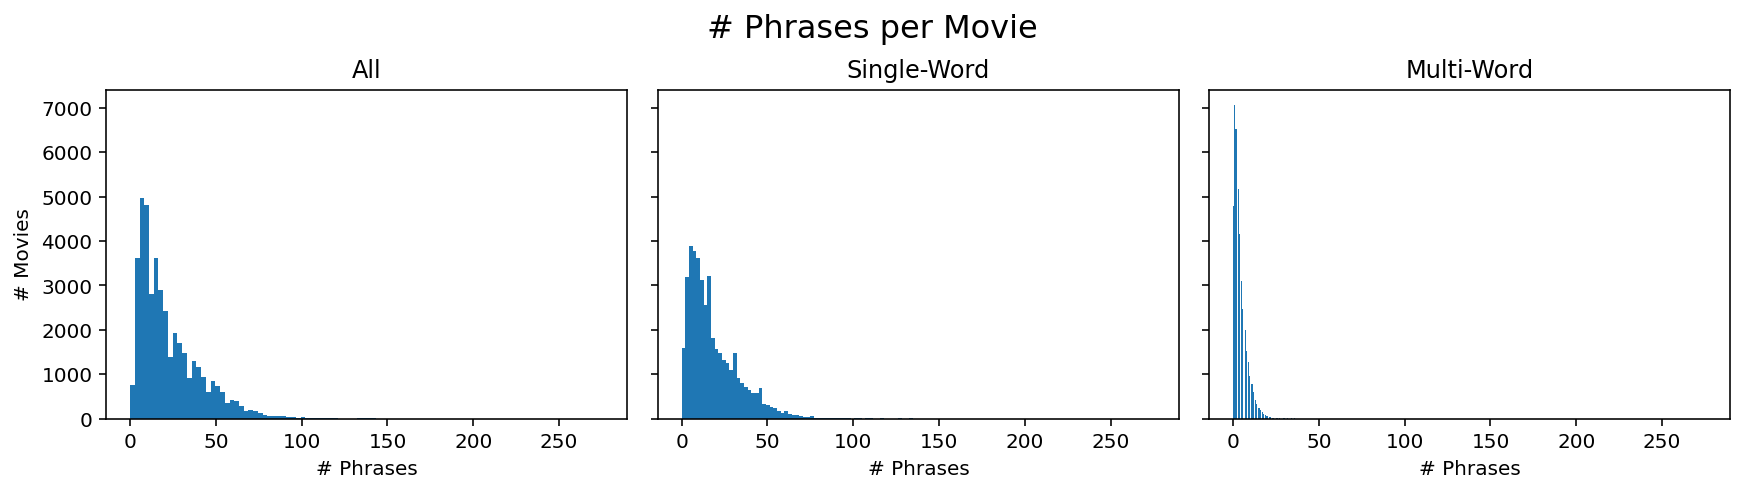

In [16]:
def single_multi_count(x):
    multi_count = len([phrase for phrase in x if re.search('\s', phrase)])
    return pd.Series({'Single-Word': len(x) - multi_count, 'Multi-Word': multi_count})

single_multi_counts = df.phrases.apply(single_multi_count)

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 3), constrained_layout=True)
fig.suptitle('# Phrases per Movie', size=16, y=1.09)
axes[0].hist(df.phrases.str.len(), bins=100)
axes[1].hist(single_multi_counts['Single-Word'], bins=100)
axes[2].hist(single_multi_counts['Multi-Word'], bins=100)
axes[0].set(title='All', xlabel='# Phrases', ylabel='# Movies')
axes[1].set(title='Single-Word', xlabel='# Phrases')
axes[2].set(title='Multi-Word', xlabel='# Phrases');

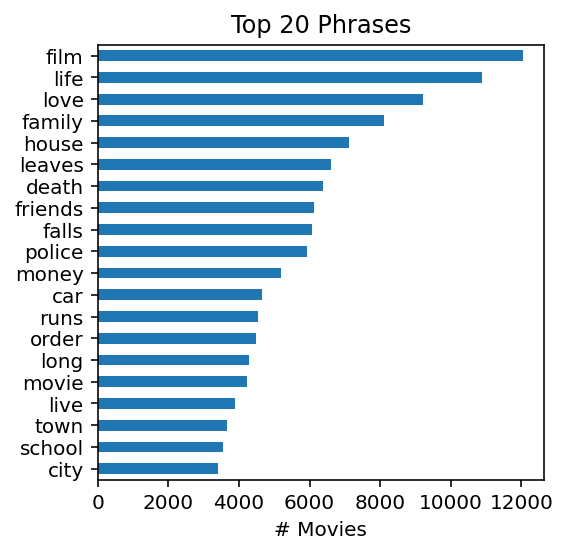

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))
n = 20
df.phrases.explode().value_counts().nlargest(n)[::-1].plot.barh(ax=ax);
ax.set(title=f'Top {n} Phrases', xlabel='# Movies');

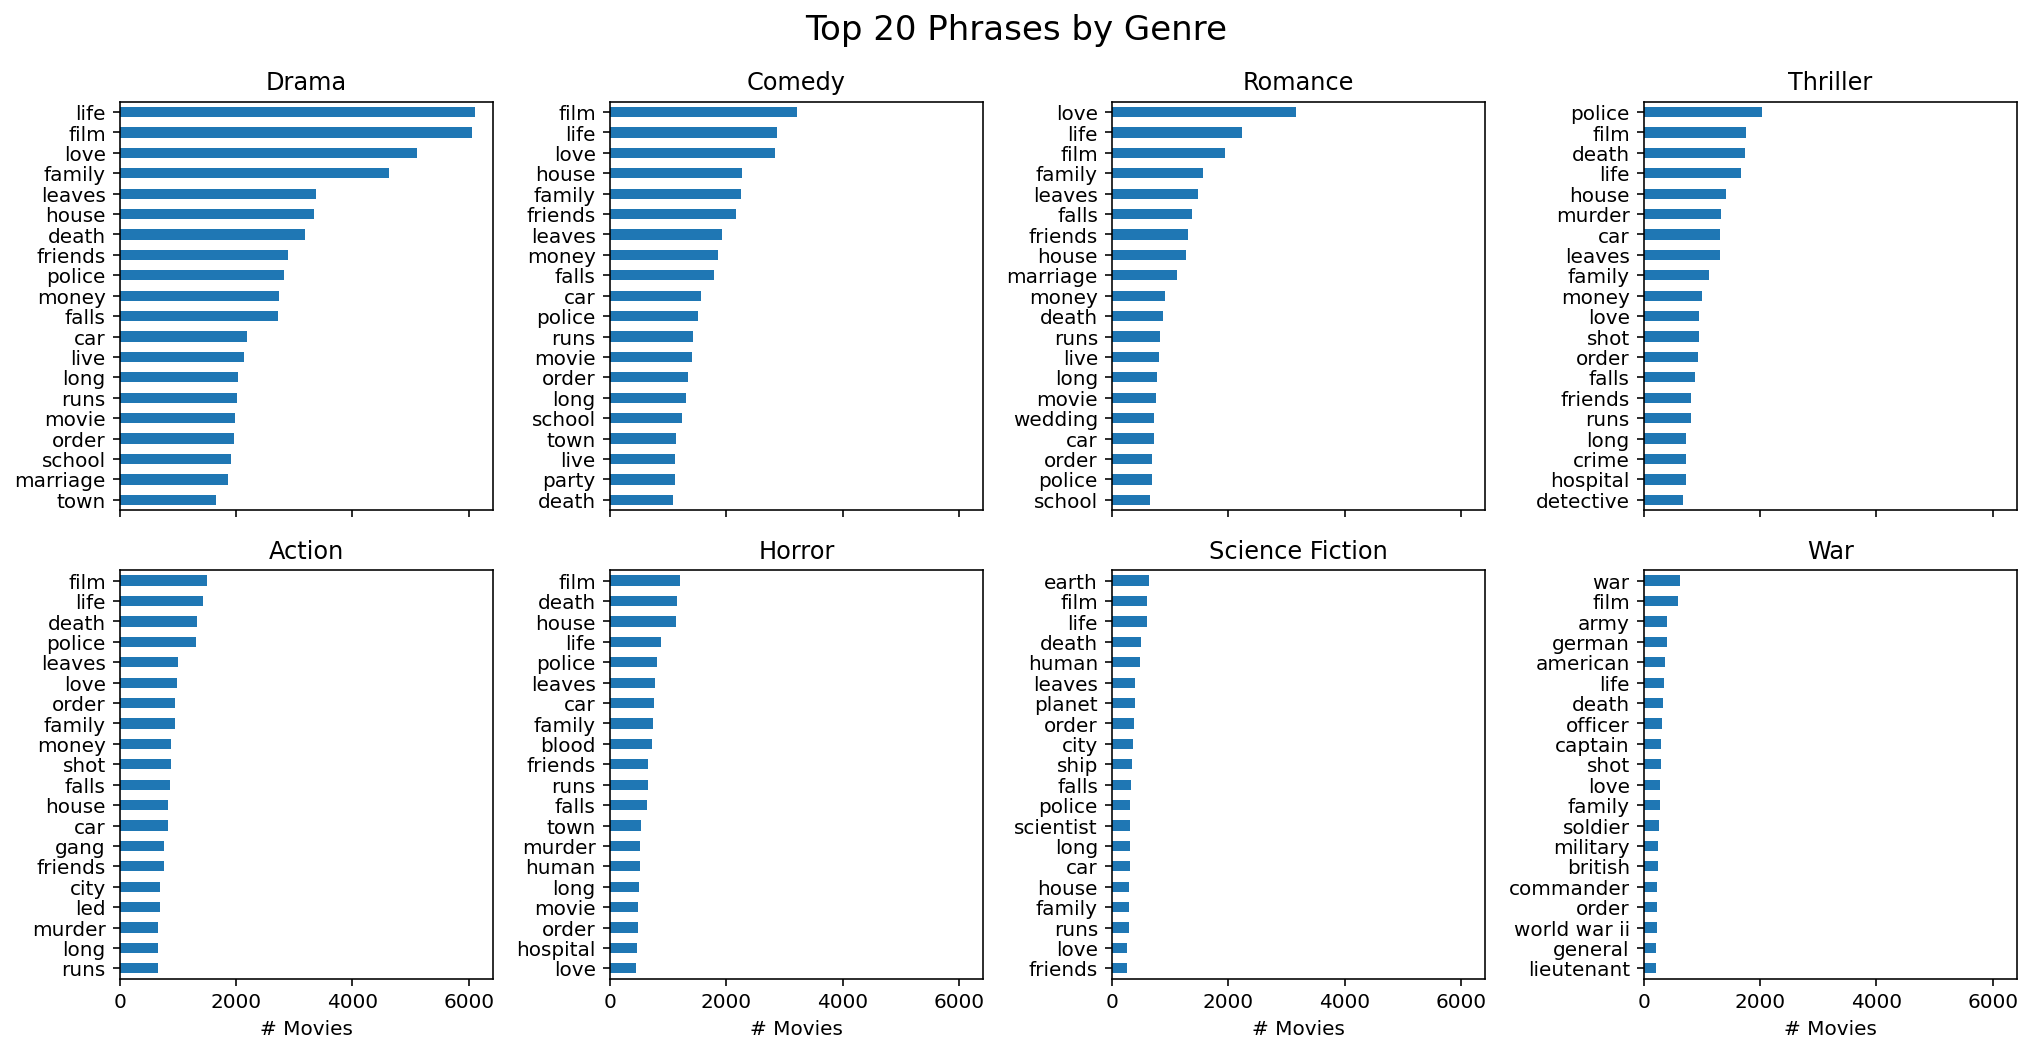

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7.2), sharex=True, constrained_layout=True)
n = 20
fig.suptitle(f'Top {n} Phrases by Genre', size=17)
for genre, ax in zip(['Drama', 'Comedy', 'Romance', 'Thriller', 'Action', 'Horror', 'Science Fiction', 'War'], axes.flatten()):
    df.phrases[df.genres.apply(lambda x: genre in x if x else False)].explode().value_counts().nlargest(n)[::-1].plot.barh(ax=ax)
    ax.set(title=genre, xlabel='# Movies')

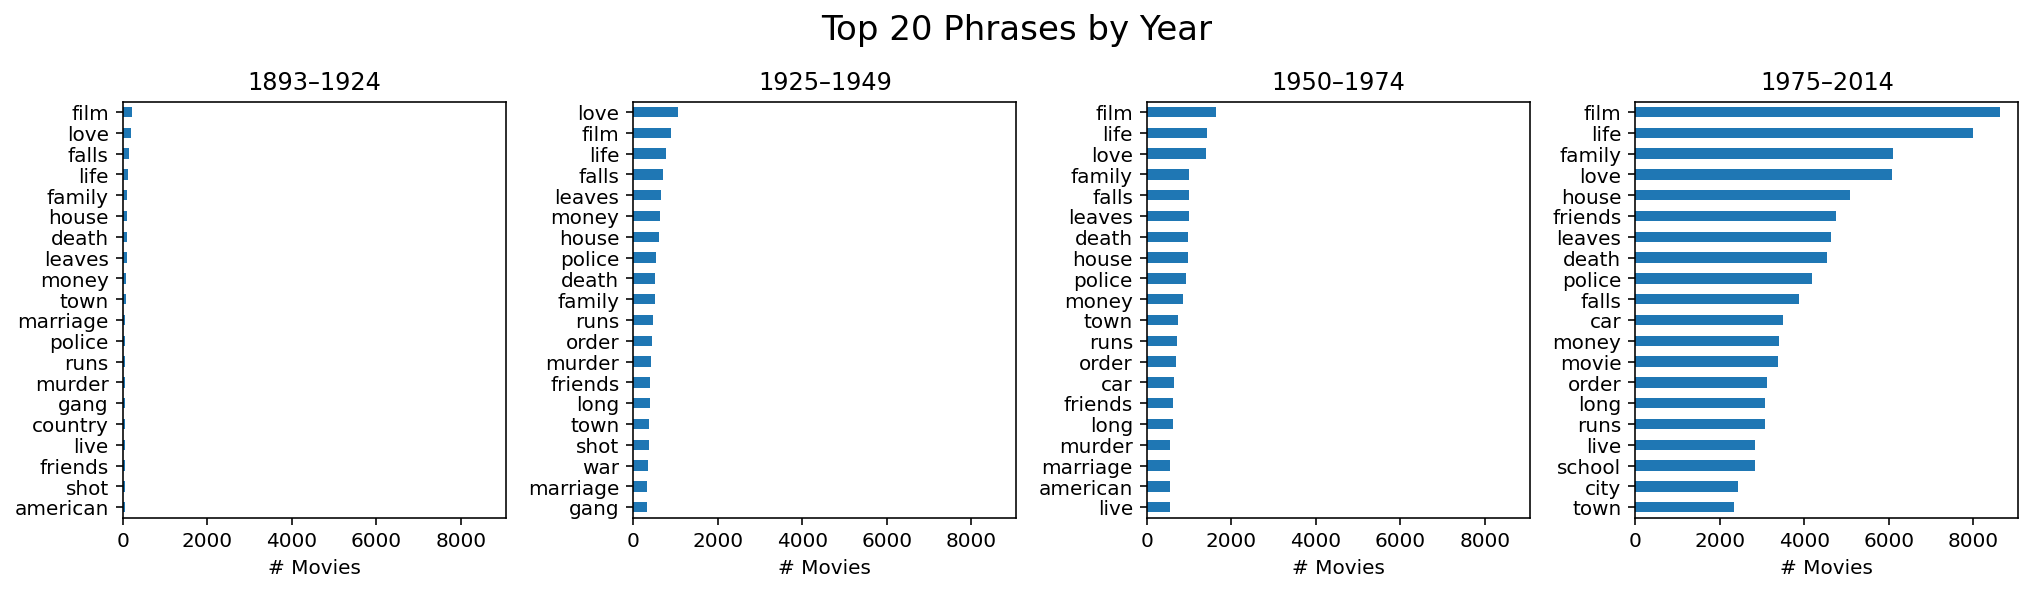

In [19]:
fig, axes = plt.subplots(1, 4,  sharex=True, figsize=(14, 4), constrained_layout=True)
n = 20
fig.suptitle(f'Top {n} Phrases by Year', size=17)
year_binned = pd.cut(
    df.date.dt.year,
    bins=[-np.inf, 1925, 1950, 1975, np.inf],
    right=False,
    labels=f'{df.date.min().year}–1924 1925–1949 1950–1974 1975–{df.date.max().year}'.split(),
)
for year_bin, ax in zip(year_binned.cat.categories, axes.flatten()):
    df.phrases[year_binned.eq(year_bin)].explode().value_counts().nlargest(n)[::-1].plot.barh(ax=ax)
    ax.set(title=year_bin, xlabel='# Movies')